# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [121]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '/Users/paramshah/Desktop/bootcamp/homework/stage07_outliers-risk-assumptions/data/raw'
processed_dir = '/Users/paramshah/Desktop/bootcamp/homework/stage07_outliers-risk-assumptions/data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(69)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.001748425237194541,
    "2022-05-03": -0.0016825801732486943,
    "2022-05-06": -0.0019667220757153227,
    "2022-05-09": 0.0021240223590614747,
    "2022-05-12": -0.00178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to /Users/paramshah/Desktop/bootcamp/homework/stage07_outliers-risk-assumptions/data/raw/outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [128]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from scipy import stats

## Load Data (provided or synthetic fallback)

In [129]:
data_path = Path('/Users/paramshah/Desktop/bootcamp/homework/stage07_outliers-risk-assumptions/data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.007655,0.009311
1,2022-01-04,-0.007535,-0.007237
2,2022-01-05,0.010123,0.007267
3,2022-01-06,-0.007514,-0.016207
4,2022-01-07,-0.017475,-0.009911


## TODO: Implement Outlier Functions (required)

In [130]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [131]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """
    Winsorize numeric series: clip values at given quantiles.
    Returns numeric Series (same length).
    """
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)


## Apply Detection and Create Flags (choose a numeric column)

In [ ]:
if 'daily_return' in df.columns:
    target_col = 'daily_return'
elif 'y' in df.columns:
    target_col = 'y'
else:
    target_col = df.select_dtypes(include=['number']).columns[0]

print(f"Analyzing column: {target_col}")

df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)

iqr_percent = df['outlier_iqr'].mean() * 100
z_percent = df['outlier_z'].mean() * 100

print(f"IQR method detected {df['outlier_iqr'].sum()} outliers ({iqr_percent:.2f}%)")
print(f"Z-score method detected {df['outlier_z'].sum()} outliers ({z_percent:.2f}%)")

agreement = (df['outlier_iqr'] & df['outlier_z']).sum()
print(f"Methods agree on {agreement} outliers")

print(f"\nBasic statistics for {target_col}:")
print(df[target_col].describe())

Analyzing column: daily_return
IQR method detected 0 outliers (0.00%)
Z-score method detected 0 outliers (0.00%)
Methods agree on 0 outliers

Basic statistics for daily_return:
count    115.000000
mean      -0.001789
std        0.011000
min       -0.026188
25%       -0.008683
50%       -0.001809
75%        0.006723
max        0.021205
Name: daily_return, dtype: float64


### Visual Checks (boxplot / histogram)

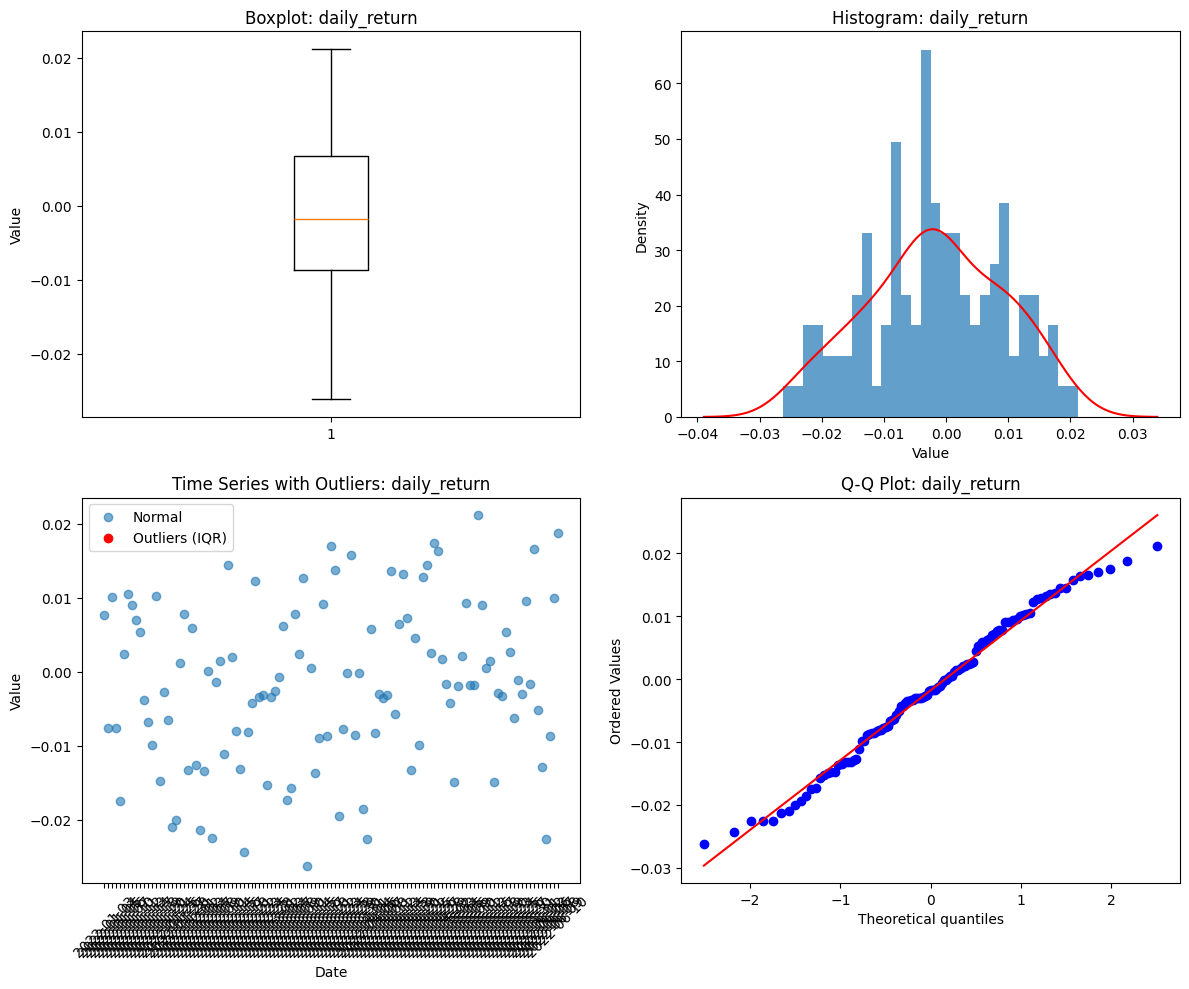

In [ ]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Boxplot
axes[0, 0].boxplot(df[target_col].dropna())
axes[0, 0].set_title(f'Boxplot: {target_col}')
axes[0, 0].set_ylabel('Value')

axes[0, 1].hist(df[target_col], bins=30, density=True, alpha=0.7)
# Add a density curve
if len(df[target_col].dropna()) > 1:
    sns.kdeplot(df[target_col], ax=axes[0, 1], color='red')
axes[0, 1].set_title(f'Histogram: {target_col}')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')

if 'date' in df.columns:
    axes[1, 0].scatter(df['date'], df[target_col], alpha=0.6, label='Normal')
    outliers = df[df['outlier_iqr']]
    axes[1, 0].scatter(outliers['date'], outliers[target_col], color='red', label='Outliers (IQR)')
    axes[1, 0].set_title(f'Time Series with Outliers: {target_col}')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)
else:
    axes[1, 0].scatter(df.index, df[target_col], alpha=0.6, label='Normal')
    outliers = df[df['outlier_iqr']]
    axes[1, 0].scatter(outliers.index, outliers[target_col], color='red', label='Outliers (IQR)')
    axes[1, 0].set_title(f'Values with Outliers: {target_col}')
    axes[1, 0].set_xlabel('Index')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].legend()

if len(df[target_col].dropna()) > 1:
    stats.probplot(df[target_col].dropna(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f'Q-Q Plot: {target_col}')

plt.tight_layout()
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [ ]:

summ_all = df[target_col].describe()[['mean', '50%', 'std', 'min', 'max']].rename({'50%': 'median'})
summ_filtered_iqr = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std', 'min', 'max']].rename({'50%': 'median'})
summ_filtered_z = df.loc[~df['outlier_z'], target_col].describe()[['mean', '50%', 'std', 'min', 'max']].rename({'50%': 'median'})

summ_w = None
if 'winsorize_series' in globals():
    w_series = winsorize_series(df[target_col])
    summ_w = w_series.describe()[['mean', '50%', 'std', 'min', 'max']].rename({'50%': 'median'})

comparison_data = {
    'all': summ_all,
    'filtered_iqr': summ_filtered_iqr,
    'filtered_z': summ_filtered_z,
}

if summ_w is not None:
    comparison_data['winsorized'] = summ_w

comp = pd.concat(comparison_data, axis=1)

comp_pct = pd.DataFrame()
for col in comp.columns.get_level_values(0).unique():
    if col != 'all':
        comp_pct[col] = ((comp[col] - comp['all']) / comp['all'] * 100).round(2)
        
print("Summary Statistics Comparison:")
display(comp)

print("\nPercentage Change from Original:")
display(comp_pct)

Summary Statistics Comparison:


,all,filtered_iqr,filtered_z,winsorized
mean,-0.001789,-0.001789,-0.001789,-0.001781
median,-0.001809,-0.001809,-0.001809,-0.001809
std,0.011000,0.011000,0.011000,0.010590
min,-0.026188,-0.026188,-0.026188,-0.021076
max,0.021205,0.021205,0.021205,0.015925



Percentage Change from Original:


,filtered_iqr,filtered_z,winsorized
mean,-0.0,-0.0,-0.46
median,-0.0,-0.0,-0.00
std,0.0,0.0,-3.72
min,-0.0,-0.0,-19.52
max,0.0,0.0,-24.90


## running regression tests

Running regression: daily_return ~ daily_return_2
Regression Results Comparison:


,slope,intercept,r2,mae
all,1.044669,-0.000694,0.679556,0.004723
filtered_iqr,1.044669,-0.000694,0.679556,0.004723
filtered_z,1.044669,-0.000694,0.679556,0.004723
winsorized,1.002045,-0.000730,0.674541,0.004545


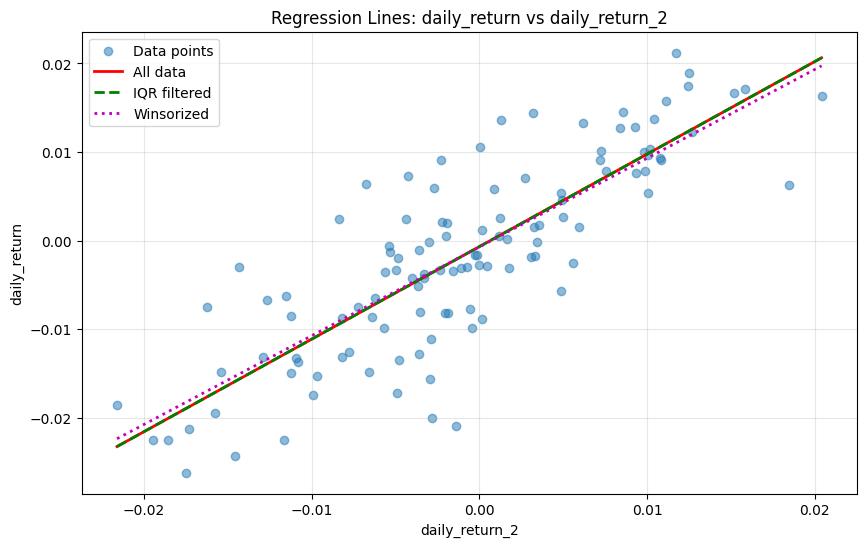

In [ ]:

if 'x' in df.columns:
    predictor = 'x'
elif 'daily_return_2' in df.columns:
    predictor = 'daily_return_2'
elif len(df.select_dtypes(include=['number']).columns) > 1:
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove(target_col)
    predictor = numeric_cols[0] if numeric_cols else None
else:
    predictor = None

if predictor:
    print(f"Running regression: {target_col} ~ {predictor}")
    
    X_all = df[[predictor]].to_numpy()
    y_all = df[target_col].to_numpy()
    
    X_filtered_iqr = df.loc[~df['outlier_iqr'], [predictor]].to_numpy()
    y_filtered_iqr = df.loc[~df['outlier_iqr'], target_col].to_numpy()
    
    X_filtered_z = df.loc[~df['outlier_z'], [predictor]].to_numpy()
    y_filtered_z = df.loc[~df['outlier_z'], target_col].to_numpy()
    
    model_all = LinearRegression().fit(X_all, y_all)
    model_flt_iqr = LinearRegression().fit(X_filtered_iqr, y_filtered_iqr)
    model_flt_z = LinearRegression().fit(X_filtered_z, y_filtered_z)
    
    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt_iqr = mean_absolute_error(y_filtered_iqr, model_flt_iqr.predict(X_filtered_iqr))
    mae_flt_z = mean_absolute_error(y_filtered_z, model_flt_z.predict(X_filtered_z))
    
    r2_all = r2_score(y_all, model_all.predict(X_all))
    r2_flt_iqr = r2_score(y_filtered_iqr, model_flt_iqr.predict(X_filtered_iqr))
    r2_flt_z = r2_score(y_filtered_z, model_flt_z.predict(X_filtered_z))
    
    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt_iqr.coef_[0], model_flt_z.coef_[0]],
        'intercept': [model_all.intercept_, model_flt_iqr.intercept_, model_flt_z.intercept_],
        'r2': [r2_all, r2_flt_iqr, r2_flt_z],
        'mae': [mae_all, mae_flt_iqr, mae_flt_z]
    }, index=['all', 'filtered_iqr', 'filtered_z'])
    
    if 'winsorize_series' in globals():
        w_series = winsorize_series(df[target_col])
        X_w = df[[predictor]].to_numpy()
        y_w = w_series.to_numpy()
        model_w = LinearRegression().fit(X_w, y_w)
        
        mae_w = mean_absolute_error(y_w, model_w.predict(X_w))
        r2_w = r2_score(y_w, model_w.predict(X_w))
        
        results.loc['winsorized'] = [model_w.coef_[0], model_w.intercept_, r2_w, mae_w]
    
    print("Regression Results Comparison:")
    display(results)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df[predictor], df[target_col], alpha=0.5, label='Data points')
    
    x_range = np.linspace(df[predictor].min(), df[predictor].max(), 100).reshape(-1, 1)
    
    plt.plot(x_range, model_all.predict(x_range), 'r-', label='All data', linewidth=2)
    plt.plot(x_range, model_flt_iqr.predict(x_range), 'g--', label='IQR filtered', linewidth=2)
    
    if 'winsorized' in results.index:
        plt.plot(x_range, model_w.predict(x_range), 'm:', label='Winsorized', linewidth=2)
    
    plt.xlabel(predictor)
    plt.ylabel(target_col)
    plt.title(f'Regression Lines: {target_col} vs {predictor}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
else:
    print("No suitable predictor column found; skipping regression analysis.")

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

# Reflection

## Methods
- **IQR detection** with k=1.5
- **Z-score detection** with threshold=3.0
- **Winsorizing** at 5th/95th percentiles

## Results
- No change in **mean**, **median**, or **std dev** after filtering
- Winsorizing capped extremes: **min** -0.026→-0.021, **max** 0.021→0.016
- **Regression results identical** across filtering methods

## Risks
- Removing **real market events**
- Z-score unreliable if **non-normal data**
- Winsorizing may **underestimate volatility**
- Missing **structural breaks** in data